In [1]:
# initialization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader
import re
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

nltk.download('punkt')
nltk.download('stopwords')

np.random.seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Import data

In [ ]:
%%script false --no-raise-error # comment this if you dont have the dev_set

# import dataset
train_set = pd.read_csv('train.csv')

test_set = pd.read_csv('test.csv')

# from train_set sample development set
dev_set = train_set.sample(n=500, replace=False)

# remove dev set from train set
train_set = train_set.drop(dev_set.index)

# check
print(train_set.shape, dev_set.shape, test_set.shape)

# save to dataframe
dev_set.to_csv("dev_set.csv", index=False)
train_set.to_csv("train_set_modified.csv", index=False)

In [2]:
train_set = pd.read_csv('train_set_modified.csv')
dev_set = pd.read_csv('dev_set.csv')
test_set = pd.read_csv('test.csv')

## Preprocess data (averaging over word representations)


In [3]:
# word2vec

# download the word2vec-google-news-300
w2v = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [4]:
# select four classes: 0, 1, 2, 3
# 4 and 5 will be OTHERS (4)

# for train_set
train_set.loc[train_set['label-coarse'] > 4, 'label-coarse'] = 4

# for dev_set
dev_set.loc[dev_set['label-coarse'] > 4, 'label-coarse'] = 4

# for test_set
test_set.loc[test_set['label-coarse'] > 4, 'label-coarse'] = 4


In [5]:
# neural network transforming the input for each word to its final vector representation
def token(sentence):

    # keep only english words
    sentence = re.sub("[^a-zA-Z]"," ",sentence)

    # converting to lower case and splitting

    # stop word removal
    words = sentence.split()
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_words)

    # handle empty string after removing stop words
    if not len(filtered_sentence):
        filtered_sentence = sentence

    token = word_tokenize(filtered_sentence)
    return token

In [6]:
train_set['cleaned_text'] = train_set['text'].apply(token)

train_set.head()

,label-coarse,label-fine,text,cleaned_text
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]"
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]"
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]"
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]"
4,2,3,What is the full form of .com ?,"[full, form, com]"


In [21]:
max_length = train_set['cleaned_text'].str.len().max()

# get the embedding shape of the model
embed_shape = len(w2v['test'])
padded_sentences = []

for index, row in train_set.iterrows():

    sentence = row['cleaned_text']

    # get word embedding of each word
    word_embeddings = []

    for word in sentence:
        # check if the word is present in the model
        if word in w2v.key_to_index:
            word_embeddings.append(w2v[word])
        else:
             word_embeddings.append(np.zeros(shape=(embed_shape)))

    # pad sentences to max_length
    pad_width = max_length - len(sentence)

    padded_sentence = np.pad(np.array(word_embeddings), ((pad_width, 0), (0, 0)), mode= "constant", constant_values= [0])
    padded_sentences.append(padded_sentence)
    # print(padded_sentence.shape) # max_length x 300

train_set['vector'] = padded_sentences

train_set.head()


,label-coarse,label-fine,text,cleaned_text,vector
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,2,3,What is the full form of .com ?,"[full, form, com]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [22]:
def preprocess_x(dataset):
  dataset['cleaned_text'] = dataset['text'].apply(token)
  max_length = dataset['cleaned_text'].str.len().max()

  # get the embedding shape of the model
  embed_shape = len(w2v['test'])
  padded_sentences = []

  for index, row in dataset.iterrows():

      sentence = row['cleaned_text']

      # get word embedding of each word
      word_embeddings = []

      for word in sentence:
          # check if the word is present in the model
          if word in w2v.key_to_index:
              word_embeddings.append(w2v[word])
          else:
              word_embeddings.append(np.zeros(shape=(embed_shape)))

      # pad sentences to max_length
      pad_width = max_length - len(sentence)

      padded_sentence = np.pad(np.array(word_embeddings), ((pad_width, 0), (0, 0)), mode= "constant", constant_values= [0])
      padded_sentences.append(padded_sentence)


  # dataset['vector'] = padded_sentences
  # display(dataset[dataset['vector'].isna()])

  x = torch.tensor(np.array(padded_sentences))

  return x

X_dev = preprocess_x(dev_set)
X_train = preprocess_x(train_set)
print(X_train.shape)
# print(torch.isnan(x_dev).any().item())


torch.Size([4952, 18, 300])


### Prepare data for training

In [26]:
def encode_y_label(df, num_classes): # one hot encoding
  encoded_labels = df['label-coarse'].apply(lambda label: list(np.eye(num_classes)[label]))
  df['encoded-coarse-label'] = encoded_labels
  return df
  # print(df['encoded_coarse_label'])

train_set = encode_y_label(train_set, 5)
dev_set = encode_y_label(dev_set, 5)

In [27]:
# split into X and y
X_train = preprocess_x(train_set)
y_train = train_set['encoded-coarse-label']

X_dev = preprocess_x(dev_set)
y_dev = dev_set['encoded-coarse-label']

# without one hot
# X_train = train_set.drop(columns=['label-coarse', 'label-fine', 'text', 'cleaned_text', 'vector']).to_numpy()
# y_train = train_set['label-coarse']

# X_dev = dev_set.drop(columns=['label-coarse', 'label-fine', 'text', 'cleaned_text', 'vector']).to_numpy()
# y_dev = dev_set['label-coarse']

# SCALING?

# mini-batch strategy
batch_size = 32

# def collate_fn(data):
#     x, y = data
#     zipped = zip(x, y)
#     return list(zipped)

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X =torch.tensor(X, dtype=torch.float64)
        self.y =torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

train_data = CustomDataset(X_train, y_train)
dev_data = CustomDataset(X_dev, y_dev)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

<ipython-input-27-5d1b4b10b802>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X =torch.tensor(X, dtype=torch.float64)


##  LSTM model

In [98]:

HIDDEN_SIZE = 128
OUTPUT_SIZE = 5
NUM_LAYERS = 1


class simple_lstm(nn.Module):
    def __init__(
                    self,
                    input_size= 300,
                    hidden_size= HIDDEN_SIZE,
                    output_size= OUTPUT_SIZE,
                    num_layers= NUM_LAYERS,
                   # dropout_rate= 0.2,
                    bidirectional= True,
                ):

        super().__init__()
        # Model body
        self.lstm = nn.LSTM(input_size= input_size, hidden_size= hidden_size, bidirectional= bidirectional, num_layers= num_layers, batch_first= True)

        # Model head
        self.head = nn.Sequential(
            nn.Linear((2 if bidirectional else 1) * hidden_size, output_size),
           # nn.Dropout(dropout_rate),
            nn.Softmax(dim= 2)
        )

    def __call__(self, input):
        out, _ = self.lstm(input) # out dim = 32 x max_length x 256

        #  apply max pooling along the sequence dimension (dimension 1)
        # F.max_pool1d(out.permute(0, 2, 1), kernel_size=out.size(1)) # convert from batch size x num feature x seq length to  batch size x seq length x num feature
        pooled_output = F.max_pool2d(out, kernel_size=(out.size(1), 1), stride=(out.size(1), 1)) # pooled output dim = 32 x 1 x 256, out.size(1) to match max_length of dataset

        return self.head(pooled_output) # expected dim = 32 x 1 x 5
        # return out

In [102]:
input_dim = embed_shape
hidden_dim = 128
output_dim = 5
layer_dim = 300

model = simple_lstm(input_dim, 128, 5, 1)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [103]:
# REFERENCE
num_epochs = 100
best_accuracy = 0.0
max_patience = 5
current_patience = 0
dev_accuracy_list = []

for epoch in range(num_epochs):
  model.train()
  total_training_loss = 0.0
  total_dev_loss = 0.0

  for x_batch, y_batch in train_loader:
    # x_batch = x_batch.unsqueeze(1).float() # convert to 3D tensor
    # print("X_BATCH_SHAPE", x_batch.shape)
    outputs = model(x_batch.float()) # forward pass
    optimizer.zero_grad() # calculate the gradient, manually setting to 0

    # obtain the loss function
    # print(outputs.shape)
    loss = criterion(outputs.squeeze(1), y_batch)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop

    total_training_loss += loss.item()

  average_loss = total_training_loss / len(train_loader)
  print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

  # evaluate on dev set
  model.eval()
  with torch.no_grad():
    all_true_labels = []
    all_predicted_labels = []
    for inputs in dev_loader:
      x_batch, y_batch = inputs
      # x_batch = x_batch.unsqueeze(1).float()

      # forward pass
      y_pred = model(x_batch.float())
      loss = criterion(y_pred.squeeze(1), y_batch)

      total_dev_loss += loss.item()

      # print(y_pred.shape)

      predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

      # print("1", predicted_labels)

      y_batch = torch.argmax(y_batch, dim=1)

      # print(y_batch)

      all_true_labels.extend(y_batch.tolist())
      all_predicted_labels.extend(predicted_labels.tolist())

    average_dev_loss = total_dev_loss / len(dev_loader)
    print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))

  def calculate_accuracy(y_true, y_pred):
      y_true = y_true.detach().cpu().numpy()
      y_pred = y_pred.detach().cpu().numpy()
      return accuracy_score(y_true, y_pred)

  accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
  dev_accuracy_list.append(accuracy)
  print(f"Accuracy: {accuracy * 100:.2f}%")

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = model.state_dict()
  else:
    current_patience += 1
    if current_patience >= max_patience:
        print(f"Early stopping after {epoch} epochs.")
        break


Epoch: 0, training set loss: 1.48073
Epoch: 0, dev set loss: 1.36546
Accuracy: 56.00%
Epoch: 1, training set loss: 1.31373
Epoch: 1, dev set loss: 1.27881
Accuracy: 62.00%
Epoch: 2, training set loss: 1.23897
Epoch: 2, dev set loss: 1.22702
Accuracy: 68.00%
Epoch: 3, training set loss: 1.19414
Epoch: 3, dev set loss: 1.21742
Accuracy: 68.20%
Epoch: 4, training set loss: 1.16113
Epoch: 4, dev set loss: 1.17071
Accuracy: 73.00%
Epoch: 5, training set loss: 1.12739
Epoch: 5, dev set loss: 1.15662
Accuracy: 74.80%
Epoch: 6, training set loss: 1.11065
Epoch: 6, dev set loss: 1.15443
Accuracy: 75.20%
Epoch: 7, training set loss: 1.09309
Epoch: 7, dev set loss: 1.13660
Accuracy: 76.00%
Epoch: 8, training set loss: 1.07733
Epoch: 8, dev set loss: 1.12889
Accuracy: 77.20%
Epoch: 9, training set loss: 1.06456
Epoch: 9, dev set loss: 1.11958
Accuracy: 78.60%
Epoch: 10, training set loss: 1.05080
Epoch: 10, dev set loss: 1.12547
Accuracy: 77.40%
Epoch: 11, training set loss: 1.04219
Epoch: 11, dev

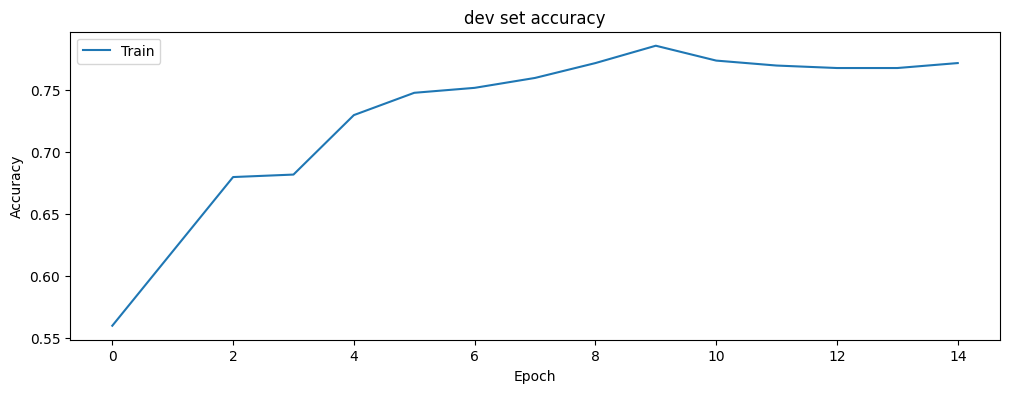

In [104]:
# Plot train and dev accurancies and losses on training and dev data against training epochs
plt.figure(figsize=(12, 4))
plt.title('dev set accuracy')
plt.plot(range(len(dev_accuracy_list)), dev_accuracy_list, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [90]:
model = simple_lstm(input_dim, hidden_dim, 5, 1)
out = model(train_data[0:2][0].float())
print(out.shape)
print(F.max_pool2d(out, kernel_size=(18, 1), stride=(18, 1)).shape)
print(F.max_pool2d(out, kernel_size=(18, 1), stride=(18, 1)))
# print(F.max_pool1d(out, kernel_size=2).shape)

torch.Size([2, 18, 256])
torch.Size([2, 1, 256])
tensor([[[ 2.7648e-02,  2.2648e-02, -3.4630e-02,  1.1953e-01,  5.3272e-02,
           1.4799e-01,  5.0330e-02,  1.6541e-01, -4.0310e-03,  3.2888e-02,
           2.7968e-02,  7.4148e-02,  1.1571e-03, -2.8010e-02,  2.8089e-02,
           1.8385e-02,  3.5669e-02,  1.9822e-02,  4.7813e-02,  1.0722e-01,
           3.2077e-02,  1.2300e-02,  1.3216e-01,  6.6913e-02,  4.8289e-02,
           6.4567e-02,  5.9575e-02,  3.6868e-02,  4.1893e-02,  4.5424e-02,
           3.1186e-02,  1.3141e-02,  6.2141e-02, -3.4058e-03,  5.7668e-03,
          -1.9928e-02,  3.5604e-02,  1.7320e-01, -1.0931e-02,  5.2010e-02,
          -6.5257e-03,  1.1509e-01, -1.6488e-02, -1.4231e-03,  9.1622e-02,
           1.7095e-02,  1.3685e-01, -1.2876e-02,  1.8756e-01,  3.1104e-02,
           8.4742e-02,  1.0944e-02,  2.8738e-03, -7.4432e-03,  9.2207e-02,
           2.6760e-02, -3.7176e-02,  1.1527e-02,  8.2210e-02,  5.5172e-02,
           8.5869e-02,  7.3715e-02, -9.8456e-04,  1

In [ ]:
print(train_data[0][0].unsqueeze(0).float().shape)

torch.Size([1, 2100])


In [ ]:
model = simple_lstm(input_dim, hidden_dim, 5, 1)

print(train_data[0][0])
print(model(train_data[0][0].unsqueeze(0).unsqueeze(1).float()))
print(train_data[1][0])
print(model(train_data[1][0].unsqueeze(0).unsqueeze(1).float()))

tensor([-1.3672e-02, -5.5435e-02,  5.6335e-02,  2.8699e-01, -1.2817e-02,
         1.0815e-01,  7.6268e-02, -1.8945e-01,  2.6489e-02,  9.4727e-02,
        -8.2932e-02, -1.2927e-01, -7.5562e-02,  1.3550e-01, -2.1545e-01,
         6.3965e-02,  2.3438e-02,  1.0641e-01,  8.1299e-02, -5.7861e-02,
         1.5720e-01,  6.5674e-02,  9.9609e-02, -1.8921e-02,  8.1805e-02,
         1.9151e-01, -5.1636e-02,  3.1158e-02, -4.8569e-02,  9.5520e-03,
        -5.0186e-02, -9.7717e-02, -1.5649e-01, -7.2021e-02, -1.9183e-01,
         4.8706e-02, -3.7720e-02, -4.7913e-02,  1.6888e-01,  1.0187e-01,
         6.2317e-02,  4.6509e-02,  3.3691e-01,  2.9449e-03,  1.5746e-01,
        -2.0752e-03,  3.5461e-02, -1.3672e-02, -1.7914e-01,  1.5430e-01,
        -6.2622e-02,  1.2259e-01,  4.7836e-03, -2.2766e-02, -7.5073e-03,
        -3.7155e-02, -2.4939e-01, -1.7018e-01,  1.0658e-02, -1.3232e-01,
         1.6052e-02,  7.6965e-02, -3.2574e-02, -5.1392e-02, -1.5468e-01,
        -8.0566e-02,  5.2368e-02, -1.0925e-02, -8.2

In [ ]:
# print(model(train_data[0:2][0].unsqueeze(0).float()).squeeze(0))
print(criterion(model(train_data[0:2][0].unsqueeze(0).float()).squeeze(0), train_data[0:2][1]))

print(model(train_data[0:2][0].unsqueeze(0).float()).squeeze(0).shape)
print( train_data[0:2][1].shape)

test_pred = torch.tensor(np.array([[0.5, 0.4, 0.1, 0, 0, 0, 0, 0, 0] for _ in range(150)])).float()
print(test_pred.shape)
print(torch.tensor(np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0] for _ in range(150)])).shape)
nn.functional.cross_entropy(test_pred, torch.tensor(np.array([0 for _ in range(150)])).long()), nn.functional.cross_entropy(test_pred, torch.tensor(np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0] for _ in range(150)])).float())

check
tensor(1.6062, dtype=torch.float64, grad_fn=<DivBackward1>)
check
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([150, 9])
torch.Size([150, 9])


(tensor(1.8269), tensor(1.8269))

In [ ]:
model(train_data[1][0].unsqueeze(0).unsqueeze(0).float()).shape


check


torch.Size([1, 1, 5])

- aggregation: max pooling, last word
- number of layers
- hidden dimensions
- learning rate
- mini-batch size